# Bridging Neural Dynamics: extending TRFs - Part 1

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Hugo-W/CNSP25_tutorial_HWeissbart/main/)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Hugo-W/CNSP25_tutorial_HWeissbart/blob/main/notebooks/part_1.ipynb)

Firstly, let's review our intuitive understanding behind Temporal Response Functions (TRF), then we will dive deeper and simulate signals exhibiting phase-amplitude coupling (PAC) triggered by different stimulus features and see whether one manage to extract this feature-dependent PAC using TRFs.

### Setup (Google Colab only)

> We need an extra step to make sure widgets can work in Collab notebooks, uncomment and run the cell bellow if using Google Collab, otherwise just skip this.

In [ ]:
# Uncomment and run the following two lines if you are using Google Colab
# %pip install -q ipywidgets ipympl

# from google.colab import output
# output.enable_custom_widget_manager()

In [ ]:
# Download `utils`
import requests
import os

files = ['__init__.py', 'helpers.py', 'surrogate.py', 'visu.py', 'utils.py']
# Create utils directory if it doesn't exist
os.makedirs('utils', exist_ok=True)
for f in files:
    url = f'https://raw.githubusercontent.com/Hugo-W/CNSP25_tutorial_HWeissbart/main/utils/{f}'
    response = requests.get(url)

    with open(f'utils/{f}', 'wb') as f:
        f.write(response.content)

## Imports

First let's get all the libraries, data and path setup.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import VBox, HBox, HTML, HTMLMath, Checkbox, FloatSlider, IntSlider, Dropdown, interact, Button
import tqdm.notebook as tqdm
import sys, os
# Add utils to Python path
sys.path.append('..') # access to utils.py and visu.py modules
from utils.utils import download_file, list_h5_data
from utils.visu import plot_fft
from utils.surrogate import (simulate_background_eeg, simulate_spike_events,
                             simulate_smooth_signal, create_kernel)
from utils.helpers import lowpass_filter, convolve_with_kernel, lag_matrix, lag_span, _svd_regress, svd_trf_estimation

In [3]:
# Set widget backend to use widgets:
# %matplotlib widget
# Quickly testing interactive plotting:
if False:
    figure = plt.figure(figsize=(10, 5))
    ax = figure.add_subplot(111)
    t = np.linspace(0, 2 * np.pi, 100)
    # Initialise plot:
    y = 1 * np.sin(1 * t + 0)
    line, = ax.plot(t, y)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.grid()

    def plot_oscillator(frequency, amplitude, phase, rescale_y):
        y = amplitude * np.sin(frequency * t + phase)
        # ax.clear()  # Clear the previous plot
        # ax.plot(t, y)
        line.set_ydata(y)
        ax.set_title(f'Frequency={frequency:.0f}Hz, Amplitude={amplitude:.1f}\nPhase={phase:.1f} rad')
        if rescale_y:
            ax.axes.relim()
            ax.autoscale_view(scaley=True)
        figure.canvas.draw_idle()

    interact(plot_oscillator,
            frequency=FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1),
            amplitude=FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1),
            phase=    FloatSlider(value=0.0, min=0.0, max=2*np.pi, step=0.1),
            rescale_y=Checkbox())

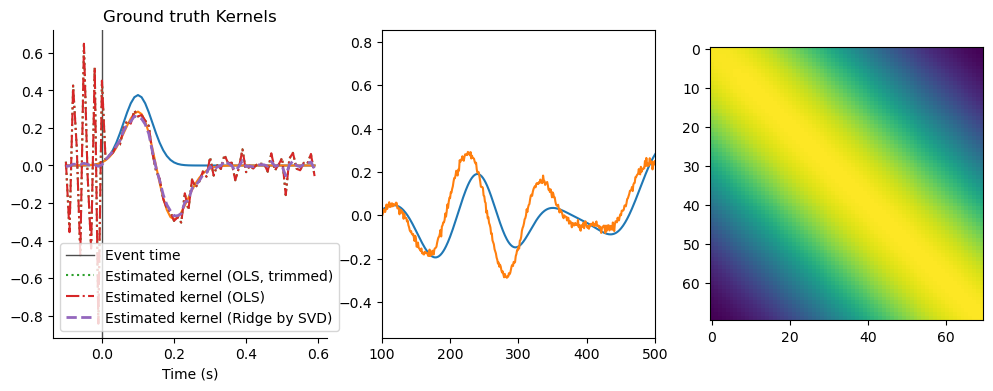

In [122]:
tker, kernel = create_kernel(spread=0.04)
_, kernel2 = create_kernel(bipolar=True, loc_peak=0.15)
stim = simulate_spike_events(n_samples=5000, event_interval=10)
stim = simulate_smooth_signal(n_samples=5000, sample_rate=100, low_pass_freq=1.)
# Visualize the kernel
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(tker, kernel)
ax[0].plot(tker, kernel2)
ax[0].set_title('Ground truth Kernels')
ax[0].axvline(0, color=[0.3]*3, linestyle='-', label='Event time', lw=1)
ax[0].set_xlabel('Time (s)')
# despine
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].set_xlim(100,500)

ax[1].plot(stim)
resp = convolve_with_kernel(stim, kernel2, tmin=tker[0], tmax=tker[-1], fs=100)
resp += np.random.randn(len(resp)) * 0.01  # Add some noise
ax[1].plot(resp)
lags = lag_span(tker[0], tker[-1]+1/100, srate=100)
X = lag_matrix(stim, lags=lags)
beta0 = np.linalg.inv(X.T@X + 0.0*np.eye(len(lags)))@X.T @ resp
edges = np.where(X.sum(axis=0)==0)[0]
# Remove edges from X and resp
X_ = np.delete(X, edges, axis=1)
resp_ = np.delete(resp, edges)
beta02 = np.linalg.inv(X_.T@X_ + 0.0*np.eye(X_.shape[1]))@X_.T @ resp_
ax[0].plot(tker, beta02, label='Estimated kernel (OLS, trimmed)', ls=':')
# beta0 = np.linalg.pinv(X) @ resp # Same as above but slower
beta = _svd_regress(X, resp[:, None], alpha=[1.0e-1]).squeeze()
ax[0].plot(tker, beta0, label='Estimated kernel (OLS)', ls='-.')
ax[0].plot(tker, beta, label='Estimated kernel (Ridge by SVD)', ls='--', lw=2)
ax[0].legend()

ax[2].imshow(X.T@X)


interactive(children=(Dropdown(description='Stimulus Type:', options=('Smooth', 'Spike'), value='Smooth'), Flo…

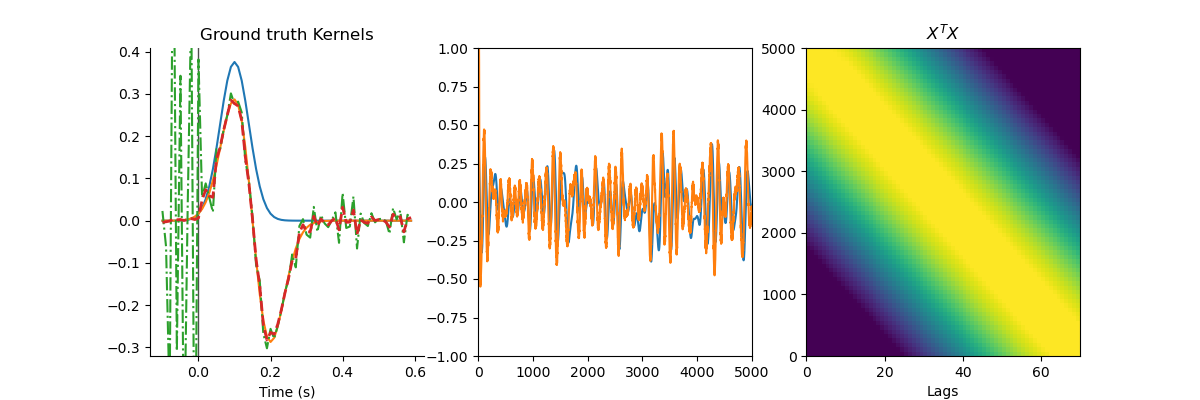

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider, Dropdown
from utils.surrogate import simulate_spike_events, simulate_smooth_signal, create_kernel
from utils.helpers import convolve_with_kernel, lag_matrix, lag_span, _svd_regress
%matplotlib widget

# Initial setup of the figure and axes
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].set_title('Ground truth Kernels')
ax[0].axvline(0, color=[0.3] * 3, linestyle='-', label='Event time', lw=1)
ax[0].set_xlabel('Time (s)')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

tker, kernel = create_kernel(spread=0.04)
_, kernel2 = create_kernel(bipolar=True, loc_peak=0.15)
kernel_line, = ax[0].plot(tker, kernel, label='Kernel')
kernel2_line, = ax[0].plot(tker, kernel2, label='Kernel2')
stim_line, = ax[1].plot([], [], label='Stimulus')
resp_line, = ax[1].plot([], [], label='Response')
beta_ols_line, = ax[0].plot([], [], label='Estimated kernel (OLS)', ls='-.')
beta_ridge_line, = ax[0].plot([], [], label='Estimated kernel (Ridge by SVD)', ls='--', lw=2)
im = ax[2].imshow(np.zeros((len(kernel), len(kernel))), aspect='auto')  # Placeholder for the image
im = ax[2].imshow(X.T@X, aspect='auto')  # Placeholder for the image
ax[2].set_title('$X^TX$')
ax[2].set_xlabel('Lags')
ax[1].set_xlim(0, 5000)
ax[1].set_ylim(-1, 1)

def interactive_demo(stim_type, low_pass_freq, alpha, event_interval):
    if stim_type == 'Spike':
        stim = simulate_spike_events(n_samples=5000, event_interval=event_interval)
    else:
        stim = simulate_smooth_signal(n_samples=5000, sample_rate=100, low_pass_freq=low_pass_freq)
    
    stim_line.set_data(np.arange(len(stim)), stim)

    resp = convolve_with_kernel(stim, kernel2, tmin=tker[0], tmax=tker[-1], fs=100)
    resp += np.random.randn(len(resp)) * 0.01  # Add some noise
    resp_line.set_data(np.arange(len(resp)), resp)

    lags = lag_span(tker[0], tker[-1]+1/100, srate=100)
    X = lag_matrix(stim, lags=lags)
    try:
        beta0 = np.linalg.inv(X.T @ X + 0.0 * np.eye(len(lags))) @ X.T @ resp
    except np.linalg.LinAlgError:
        print("Singular matrix encountered in OLS estimation.")
        beta0 = np.zeros(len(lags)) * np.nan
    edges = np.where(X.sum(axis=0) == 0)[0]
    
    X_ = np.delete(X, edges, axis=1)
    resp_ = np.delete(resp, edges)
    try:
        beta02 = np.linalg.inv(X_.T @ X_ + 0.0 * np.eye(X_.shape[1])) @ X_.T @ resp_
    except np.linalg.LinAlgError:
        print("Singular matrix encountered in OLS estimation (trimmed).")
        beta02 = np.zeros(X_.shape[1]) * np.nan
    
    beta_ols_line.set_data(tker, beta0)
    beta = _svd_regress(X, resp[:, None], alpha=[alpha]).squeeze()
    beta_ridge_line.set_data(tker, beta)
    im.set_data(X.T @ X)
    im.set_extent([0, X.T.shape[0], 0, X.T.shape[1]])

    fig.canvas.draw_idle()

interact(interactive_demo,
         stim_type=Dropdown(options=['Smooth', 'Spike'], value='Smooth', description='Stimulus Type:'),
         low_pass_freq=FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='Low Pass Freq:'),
         alpha=FloatSlider(value=0.1, min=0.01, max=1.0, step=0.01, description='Ridge Alpha:'),
         event_interval=IntSlider(value=10, min=1, max=100, step=1, description='Spike Interval:')
        );